# Import libraries and set file paths

In [4]:
# Block 1: Setup and imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.stats import ttest_ind, spearmanr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report
import warnings, os

warnings.filterwarnings("ignore")

# File paths (update if needed)
trader_path = "/content/sample_data/historical_data.csv"
sent_path   = "/content/sample_data/fear_greed_index.csv"


# Load the datasets

In [5]:
# Block 2: Load data

# Load sentiment (Fear-Greed)
sent = pd.read_csv(sent_path)

# Load trader data
trader = pd.read_csv(trader_path)

# Preview
print("Sentiment dataset shape:", sent.shape)
print(sent.head(3), "\n")

print("Trader dataset shape:", trader.shape)
print(trader.head(3))


Sentiment dataset shape: (2644, 4)
    timestamp  value classification        date
0  1517463000     30           Fear  2018-02-01
1  1517549400     15   Extreme Fear  2018-02-02
2  1517635800     40           Fear  2018-02-03 

Trader dataset shape: (211224, 16)
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   

   Size Tokens  Size USD Side    Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  2/12/2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  2/12/2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  2/12/2024 22:50     1002.518996       Buy   

   Closed PnL                                   Transaction Hash     Order ID  \
0         0.0  0xec09451986a1874e3a980418412fcd0201f500c95bac

# Identify and clean key columns

In [6]:
# Block 3: Identify columns dynamically
def find_col(cols, keywords):
    for kw in keywords:
        for c in cols:
            if kw.lower() in c.lower().replace(" ", "") or kw.lower() in c.lower():
                return c
    return None

cols = list(trader.columns)

time_col      = find_col(cols, ['time','timestamp','date'])
size_col      = find_col(cols, ['size','qty','quantity','amount'])
pnl_col       = find_col(cols, ['pnl','profit','closed'])
leverage_col  = find_col(cols, ['leverage','lev'])
side_col      = find_col(cols, ['side','direction'])
symbol_col    = find_col(cols, ['symbol','pair'])
price_col     = find_col(cols, ['price','execution'])

print("Detected columns:")
print(f"Time: {time_col}, Size: {size_col}, PnL: {pnl_col}, Leverage: {leverage_col}, Side: {side_col}, Symbol: {symbol_col}, Price: {price_col}")


Detected columns:
Time: Timestamp IST, Size: Size Tokens, PnL: Closed PnL, Leverage: None, Side: Side, Symbol: None, Price: Execution Price


# Data cleaning and normalization

In [7]:
# Block 4: Clean and preprocess trader data
if time_col is None:
    raise ValueError("No time column detected in trader dataset!")

trader['time'] = pd.to_datetime(trader[time_col], errors='coerce')
trader = trader.dropna(subset=['time'])
trader['trade_date'] = trader['time'].dt.normalize()

# Rename detected columns
rename_map = {}
if size_col: rename_map[size_col] = 'size'
if pnl_col: rename_map[pnl_col] = 'closedPnL'
if leverage_col: rename_map[leverage_col] = 'leverage'
if side_col: rename_map[side_col] = 'side'
if symbol_col: rename_map[symbol_col] = 'symbol'
if price_col: rename_map[price_col] = 'execution_price'

trader = trader.rename(columns=rename_map)

# Convert numeric columns safely
for col in ['size', 'closedPnL', 'leverage', 'execution_price']:
    if col in trader.columns:
        trader[col] = pd.to_numeric(trader[col], errors='coerce')

print("Cleaned trader dataset preview:")
print(trader.head(3))


Cleaned trader dataset preview:
                                      Account  Coin  execution_price    size  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769  986.87   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   16.00   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855  144.09   

   Size USD side    Timestamp IST  Start Position Direction  closedPnL  \
0   7872.16  BUY  2/12/2024 22:50        0.000000       Buy        0.0   
1    127.68  BUY  2/12/2024 22:50      986.524596       Buy        0.0   
2   1150.63  BUY  2/12/2024 22:50     1002.518996       Buy        0.0   

                                    Transaction Hash     Order ID  Crossed  \
0  0xec09451986a1874e3a980418412fcd0201f500c95bac...  52017706630     True   
1  0xec09451986a1874e3a980418412fcd0201f500c95bac...  52017706630     True   
2  0xec09451986a1874e3a980418412fcd0201f500c95bac...  52017706630     True   

        Fee      Trade ID     Timesta

# Prepare sentiment dataset

In [8]:
# Block 5: Clean sentiment data
sent_cols = list(sent.columns)
sent_date_col  = find_col(sent_cols, ['date','time','timestamp'])
sent_class_col = find_col(sent_cols, ['class','classification','sentiment','fear','greed','value'])

if sent_date_col is None:
    raise ValueError("No date column found in sentiment dataset!")

sent = sent.rename(columns={sent_date_col: 'Date'})
sent['Date'] = pd.to_datetime(sent['Date'], errors='coerce').dt.normalize()

# If classification column missing, map from numeric index if exists
if sent_class_col and sent_class_col != 'Date':
    sent = sent.rename(columns={sent_class_col: 'Classification'})
elif 'value' in sent.columns:
    def classify(v):
        try: v = float(v)
        except: return 'Unknown'
        if v <= 25: return 'Extreme Fear'
        if v <= 45: return 'Fear'
        if v <= 55: return 'Neutral'
        if v <= 75: return 'Greed'
        return 'Extreme Greed'
    sent['Classification'] = sent['value'].apply(classify)
else:
    sent['Classification'] = 'Unknown'

print("Sentiment preview:")
print(sent.head(3))


Sentiment preview:
    timestamp  value Classification       Date
0  1517463000     30           Fear 2018-02-01
1  1517549400     15   Extreme Fear 2018-02-02
2  1517635800     40           Fear 2018-02-03


# Aggregate trader data daily

In [9]:
# Block 6: Daily aggregation
agg_dict = {}
if 'size' in trader.columns: agg_dict['size'] = ['sum','mean']
if 'closedPnL' in trader.columns: agg_dict['closedPnL'] = ['sum','mean']
if 'leverage' in trader.columns: agg_dict['leverage'] = ['mean']
agg_dict['time'] = ['count']

daily = trader.groupby('trade_date').agg(agg_dict)
daily.columns = ['_'.join(col).strip() for col in daily.columns]
daily = daily.reset_index().rename(columns={'trade_date': 'Date'})
daily['Date'] = pd.to_datetime(daily['Date']).dt.normalize()

# Win rate
if 'closedPnL' in trader.columns:
    win_rate = trader.groupby('trade_date')['closedPnL'].apply(lambda x: (x>0).mean())
    daily['win_rate'] = win_rate.values

print("Daily summary:")
print(daily.head(3))


Daily summary:
        Date    size_sum   size_mean  closedPnL_sum  closedPnL_mean  \
0 2023-01-05     0.25130    0.083767        0.00000        0.000000   
1 2023-05-12    11.80901    1.312112        0.00000        0.000000   
2 2024-01-01  4178.78664  232.154813     -129.53146       -7.196192   

   time_count  win_rate  
0           3  0.000000  
1           9  0.000000  
2          18  0.055556  


# Merge sentiment and trading data

In [10]:
# Block 7: Merge with sentiment
merged = pd.merge(daily, sent[['Date', 'Classification']], on='Date', how='left')
merged['Classification'] = merged['Classification'].fillna('Unknown')

# Map to numeric sentiment score
sent_map = {'Extreme Fear': -2, 'Fear': -1, 'Neutral': 0, 'Greed': 1, 'Extreme Greed': 2}
merged['sent_score'] = merged['Classification'].map(sent_map).fillna(0)

print("Merged dataset:")
print(merged.head(5))


Merged dataset:
        Date      size_sum      size_mean  closedPnL_sum  closedPnL_mean  \
0 2023-01-05  2.513000e-01       0.083767       0.000000        0.000000   
1 2023-05-12  1.180901e+01       1.312112       0.000000        0.000000   
2 2024-01-01  4.178787e+03     232.154813    -129.531460       -7.196192   
3 2024-01-02  4.498600e+04    7497.666667       0.000000        0.000000   
4 2024-01-03  2.598468e+07  189669.167883    8244.241409       60.176945   

   time_count  win_rate Classification  sent_score  
0           3  0.000000           Fear        -1.0  
1           9  0.000000        Neutral         0.0  
2          18  0.055556          Greed         1.0  
3           6  0.000000          Greed         1.0  
4         137  0.934307          Greed         1.0  


# Statistical analysis



In [11]:
# Block 8: Statistical analysis
if 'closedPnL_sum' in merged.columns:
    fear = merged.loc[merged['Classification'].str.contains('Fear', na=False), 'closedPnL_sum']
    greed = merged.loc[merged['Classification'].str.contains('Greed', na=False), 'closedPnL_sum']
    if len(fear)>3 and len(greed)>3:
        t_stat, p_val = ttest_ind(greed, fear, equal_var=False, nan_policy='omit')
        print(f"T-test (Greed vs Fear): t={t_stat:.3f}, p={p_val:.4f}")

# Correlation between sentiment and performance
num_cols = [c for c in merged.columns if merged[c].dtype.kind in 'biufc']
for c in num_cols:
    if c not in ['sent_score']:
        valid = merged[[c, 'sent_score']].dropna()
        if len(valid) > 5:
            rho, p = spearmanr(valid[c], valid['sent_score'])
            print(f"Spearman correlation between {c} and sentiment: rho={rho:.3f}, p={p:.3f}")


T-test (Greed vs Fear): t=-1.149, p=0.2553
Spearman correlation between size_sum and sentiment: rho=-0.119, p=0.104
Spearman correlation between size_mean and sentiment: rho=0.053, p=0.472
Spearman correlation between closedPnL_sum and sentiment: rho=-0.103, p=0.158
Spearman correlation between closedPnL_mean and sentiment: rho=0.013, p=0.854
Spearman correlation between time_count and sentiment: rho=-0.248, p=0.001
Spearman correlation between win_rate and sentiment: rho=-0.016, p=0.830


# Predictive modeling

In [12]:
# Block 9: Logistic regression model
if 'closedPnL' in trader.columns:
    trader['profitable'] = (trader['closedPnL'] > 0).astype(int)
    trader['trade_date'] = pd.to_datetime(trader['trade_date']).dt.normalize()
    trader = pd.merge(trader, sent[['Date','Classification']], left_on='trade_date', right_on='Date', how='left')
    trader['sent_score'] = trader['Classification'].map(sent_map).fillna(0)

    features_num = [c for c in ['size','leverage'] if c in trader.columns]
    features_cat = [c for c in ['side','symbol'] if c in trader.columns]
    if features_num or features_cat:
        X = trader[features_num + features_cat + ['sent_score']].dropna()
        y = trader.loc[X.index, 'profitable']

        pre = ColumnTransformer([
            ('num', StandardScaler(), [c for c in features_num + ['sent_score'] if c in X.columns]),
            ('cat', OneHotEncoder(handle_unknown='ignore'), [c for c in features_cat if c in X.columns])
        ])
        pipe = Pipeline([('pre', pre), ('clf', LogisticRegression(max_iter=500))])

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        y_proba = pipe.predict_proba(X_test)[:,1]

        print("Model AUC:", roc_auc_score(y_test, y_proba))
        print(classification_report(y_test, y_pred))


Model AUC: 0.6661008834878682
              precision    recall  f1-score   support

           0       0.72      0.62      0.67     11441
           1       0.56      0.67      0.61      8366

    accuracy                           0.64     19807
   macro avg       0.64      0.65      0.64     19807
weighted avg       0.65      0.64      0.64     19807



# Visualization

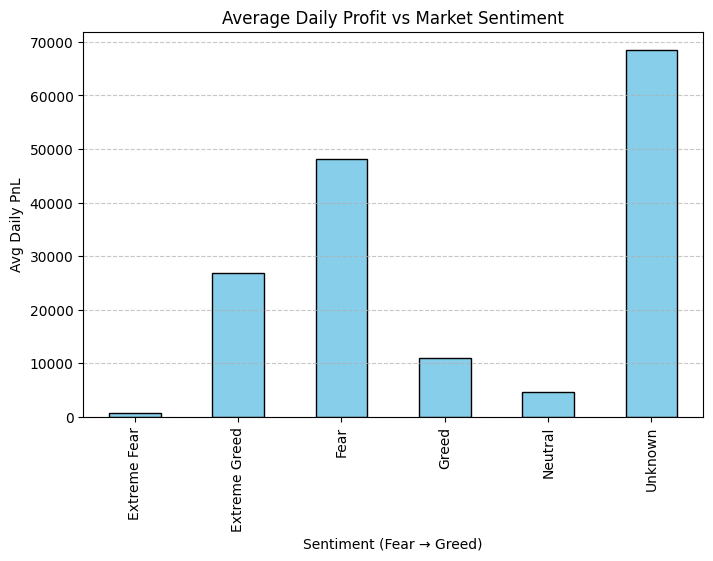

In [13]:
# Block 10: Visualization
if 'closedPnL_sum' in merged.columns:
    plt.figure(figsize=(8,5))
    merged.groupby('Classification')['closedPnL_sum'].mean().plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title("Average Daily Profit vs Market Sentiment")
    plt.xlabel("Sentiment (Fear → Greed)")
    plt.ylabel("Avg Daily PnL")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
